<a href="https://colab.research.google.com/github/sidwekhande/spike-in/blob/master/Data_Analysis_of_a_ChIP_seq_spike_in_reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis of a ChIP-seq spike-in 


---



###Background
Comparing peak-calls across multiple ChIP-seq experiments testing for different conditions is difficult, primarily because the traditional methods of RPKM, TPKM or other nomralization factors depend on the total read count of the experiment, which can vary across biological experiments. To overcome this problem, Guertin et. al. (2018) suggested using a reference spike-in, i.e., a second antibody that will give a read count proportion that is known to not change across conditions to use it as a reference for how much the first protein (target) changed.

<br>

---

###Goal

To test this, we have a set of ChIP-seq experiments that mix H3K27me3 and CTCF antibodies in varying proportions (1:20, 1:10, 1:5, and 1:1). These four experiments can be used to see if we can detect the change in CTCF read count proportion in the same ratio of the antibody proportion. This can assess if the antibody efficiency is consistent, and also serves as a good analysis of how much CTCF we should use for spike-in when testing for H3K7me3 changes across condition.

<br>



## Data Preprocessing

---

We have five ChIP-seq experiments:


1.   H3K27me3:CTCF (20:1) [Total Tag Count =  28,288,343]
2.   H3K27me3:CTCF (10:1) [Total Tag Count = 22,957,508]
1.   H3K27me3:CTCF (5:1) [Total Tag Count = 25,365,150]
2.   H3K27me3:CTCF (1:1) [Total Tag Count = 24,745,421]
3.   CTCF [Total Tag Count = 25,493,952]
4.   H3K27me3 [Total Tag Count = 23,593,070]

I aligned the reads using bowtie2 and used MACS2 on Galaxy to call peaks on the pure CTCF experiment [bed file] . This gives us the expected binding location of CTCF in all these experiments. 

I then used samtools bedcov to get the number of read counts at these positions in all the above experiments.


```
samtools bedcov [CTCF Peak calls BED] [INPUT BAM1] > [OUTPUT]
```

The files have the readcounts at expected CTCF binding positions. By looking at the normalized sum of these readcounts, we should get the ratio of read counts equal to the ratio of CTCF antibody added. 


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
from google.colab import files
uploaded = files.upload()


Saving HM_CTCF_20_1.tabular to HM_CTCF_20_1.tabular
Saving HM_CTCF_5_1.tabular to HM_CTCF_5_1.tabular
Saving HM_CTCF_1_1.tabular to HM_CTCF_1_1.tabular
Saving HM_CTCF_10_1.tabular to HM_CTCF_10_1.tabular
Saving CTCF_rc.tabular to CTCF_rc.tabular
Saving HM.tabular to HM.tabular


In [55]:
import io

#importing read counts from CTCF experiment
ctcf_rc = pd.read_csv(io.BytesIO(uploaded['CTCF_rc.tabular']),"\t", header = None)
ctcf_rc.columns = ["chr", "Start", "End", "Name","Score","Strand","ThickStart","ThinEnd","ItemRGB","BlockCount","ReadCounts"]
ctcf_rc.head()

,chr,Start,End,Name,Score,Strand,ThickStart,ThinEnd,ItemRGB,BlockCount,ReadCounts
0,chr1,3325377,3325520,EB_4hRA_-_CTCF_bam_peak_1,127,.,8.00295,15.29251,12.78554,77,3007
1,chr1,3448209,3448397,EB_4hRA_-_CTCF_bam_peak_2,258,.,12.82895,28.54597,25.82700,102,3617
2,chr1,3611304,3611552,EB_4hRA_-_CTCF_bam_peak_3,312,.,14.43074,33.99889,31.20519,121,6011
3,chr1,3841405,3841606,EB_4hRA_-_CTCF_bam_peak_4,112,.,7.62313,13.70331,11.22671,110,2409
4,chr1,4142530,4142942,EB_4hRA_-_CTCF_bam_peak_5,884,.,21.95743,92.10209,88.45210,185,13289


As you can see here, we have a columns that will not be required for our analysis. We can drop these columns in the above dataframe and ignore to import these columns in our other dataframes.

In [56]:
#drop columns

ctcf_rc.drop(columns=["Name","Score","Strand","ThickStart","ThinEnd","ItemRGB","BlockCount"],axis =1,inplace=True)
ctcf_rc.head()

,chr,Start,End,ReadCounts
0,chr1,3325377,3325520,3007
1,chr1,3448209,3448397,3617
2,chr1,3611304,3611552,6011
3,chr1,3841405,3841606,2409
4,chr1,4142530,4142942,13289


In [150]:
#similarly, importing read counts in all other experiments, but with only reqd columns
HM_rc = pd.read_csv(io.BytesIO(uploaded['HM.tabular']),"\t", header = None, usecols=[0,1,2,10])
HM_rc.columns = ["chr", "Start", "End", "ReadCounts"]
HM_CTCF_1_1_rc = pd.read_csv(io.BytesIO(uploaded['HM_CTCF_1_1.tabular']),"\t", header = None, usecols=[0,1,2,10])
HM_CTCF_1_1_rc.columns = ["chr", "Start", "End", "ReadCounts"]
HM_CTCF_5_1_rc = pd.read_csv(io.BytesIO(uploaded['HM_CTCF_5_1.tabular']),"\t", header = None, usecols=[0,1,2,10])
HM_CTCF_5_1_rc.columns = ["chr", "Start", "End", "ReadCounts"]
HM_CTCF_10_1_rc = pd.read_csv(io.BytesIO(uploaded['HM_CTCF_10_1.tabular']),"\t", header = None, usecols=[0,1,2,10])
HM_CTCF_10_1_rc.columns = ["chr", "Start", "End", "ReadCounts"]
HM_CTCF_20_1_rc = pd.read_csv(io.BytesIO(uploaded['HM_CTCF_20_1.tabular']),"\t", header = None, usecols=[0,1,2,10])
HM_CTCF_20_1_rc.columns = ["chr", "Start", "End", "ReadCounts"]
HM_CTCF_1_1_rc.head()

,chr,Start,End,ReadCounts
0,chr1,3325377,3325520,248
1,chr1,3448209,3448397,917
2,chr1,3611304,3611552,1108
3,chr1,3841405,3841606,434
4,chr1,4142530,4142942,3096


In [170]:
# Get sum of CTCF read counts in from each exp.
'''sum_df = pd.DataFrame({
    'CTCF':sum(ctcf_rc["ReadCounts"]),
    'HM_CTCF_1_1':sum(HM_CTCF_1_1_rc["ReadCounts"]),
    'HM_CTCF_5_1':sum(HM_CTCF_5_1_rc["ReadCounts"]),
    'HM_CTCF_10_1':sum(HM_CTCF_10_1_rc["ReadCounts"]),
    'HM_CTCF_20_1':sum(HM_CTCF_20_1_rc["ReadCounts"])},
    index=[0]
    
)'''
sum_df = pd.DataFrame()
#sum_df.head()
sum_df["CTCF"] = ctcf_rc["ReadCounts"]
sum_df["HM_CTCF_1_1"] = HM_CTCF_1_1_rc["ReadCounts"]
sum_df["HM_CTCF_5_1"] = HM_CTCF_5_1_rc["ReadCounts"]
sum_df["HM_CTCF_10_1"] = HM_CTCF_10_1_rc["ReadCounts"]
sum_df["HM_CTCF_20_1"] = HM_CTCF_20_1_rc["ReadCounts"]
#r = sum(HM_CTCF_1_1_rc["ReadCounts"])
#print (r)
sum_df = sum_df[(sum_df != 0).all(1)]
sum_df = sum_df[(sum_df < 250000).all(1)]
sum_df.shape

(56710, 5)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


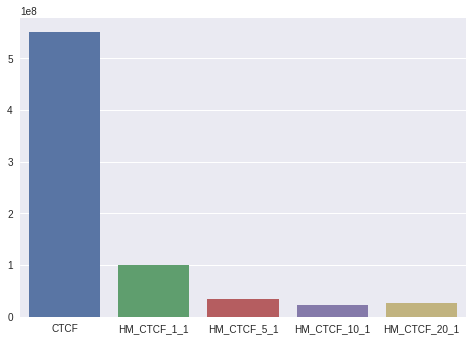

In [154]:
sum_df[sum_df > 70000].count()
#sum_df.plot(y=[sum(sum_df["CTCF"]),sum(sum_df["HM_CTCF_1_1"])])
#sum_df["CTCF"]
#ax = sum_df.plot()
ax = sns.barplot(x=list(sum_df), y = [sum(sum_df["CTCF"]), sum(sum_df["HM_CTCF_1_1"]), sum(sum_df["HM_CTCF_5_1"]), sum(sum_df["HM_CTCF_10_1"]), sum(sum_df["HM_CTCF_20_1"])])
#ax = sum_df.CTCF.plot()

Next step is a total tag normalization, to get the proportion of read counts in these regions. 

In [171]:
#Normalizing by CTCF count

'''HM_rc["ReadCounts"] = HM_rc["ReadCounts"]/23593070
HM_CTCF_1_20_rc["ReadCounts"] = HM_CTCF_1_20_rc["ReadCounts"]/23593070
HM_CTCF_1_10_rc["ReadCounts"] = HM_CTCF_1_10_rc["ReadCounts"]/22957508
HM_CTCF_1_5_rc["ReadCounts"] = HM_CTCF_1_5_rc["ReadCounts"]/25365150
HM_CTCF_1_1_rc["ReadCounts"] = HM_CTCF_1_1_rc["ReadCounts"]/24745421'''
H1_C1rc = 24745421 * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_1_1"])
H5_C1rc = 25365150 * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_5_1"])
H10_C1rc = 22957508 * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_10_1"])
H20_C1rc = 23593070 * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_20_1"])
sum_df["HM_CTCF_1_1"] = sum_df["HM_CTCF_1_1"] * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_1_1"])
#print(sum(sum_df["CTCF"]))
#print(sum(sum_df["HM_CTCF_1_1"]))
sum_df["HM_CTCF_5_1"] = sum_df["HM_CTCF_5_1"] * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_5_1"])
sum_df["HM_CTCF_10_1"] = sum_df["HM_CTCF_10_1"] * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_10_1"])
sum_df["HM_CTCF_20_1"] = sum_df["HM_CTCF_20_1"] * sum(sum_df["CTCF"])/sum(sum_df["HM_CTCF_20_1"])

#sum_df.head()
#ax = sns.barplot(x=list(sum_df), y = [sum(sum_df["CTCF"]), sum(sum_df["HM_CTCF_1_1"]), sum(sum_df["HM_CTCF_5_1"]), sum(sum_df["HM_CTCF_10_1"]), sum(sum_df["HM_CTCF_20_1"])])
print(sum(sum_df["CTCF"])) 
print(sum(sum_df["HM_CTCF_10_1"]))

548677221
548677221.000046


In [0]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


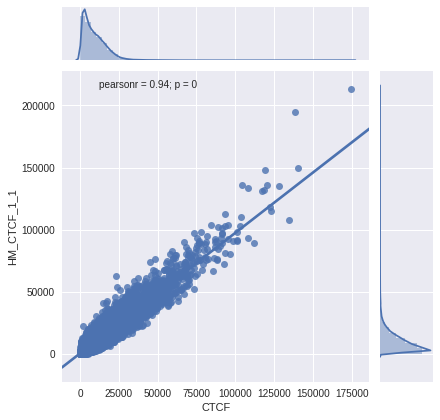

In [172]:
#Need to find better scaling for the next couple of graphs
grid1 = sns.jointplot(x = (sum_df["CTCF"]), y = sum_df["HM_CTCF_1_1"],kind ="reg")
grid1

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


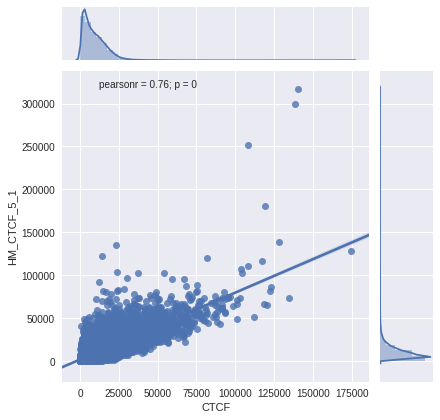

In [173]:
grid2 = sns.jointplot(x = (sum_df["CTCF"]), y = sum_df["HM_CTCF_5_1"],kind ="reg")
grid2

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


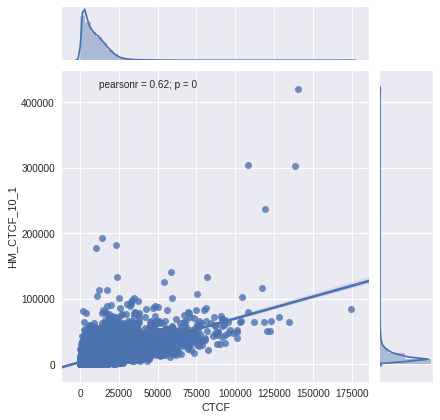

In [174]:
grid3 = sns.jointplot(x = (sum_df["CTCF"]), y = sum_df["HM_CTCF_10_1"],kind ="reg")
grid3

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


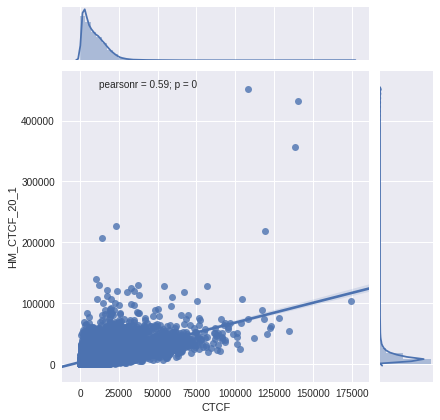

In [175]:
grid4 = sns.jointplot(x = (sum_df["CTCF"]), y = sum_df["HM_CTCF_20_1"],kind ="reg")
grid4

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


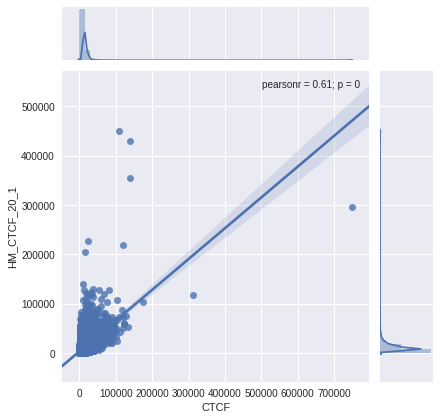

In [135]:
#Persan Correlation decreases consistently - very interesting. Try to remove outliers and see what happens.
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1 = sum_df[sum_df["HM_CTCF_20_1"]!=0]
df1 = df1[df1["HM_CTCF_20_1"] < 2000000]
#print(df1.shape)
#print(sum_df.shape)
grid5 = sns.jointplot(x = df1["CTCF"], y = df1["HM_CTCF_20_1"],kind ="reg")

#Removed outliers - zeroes and anything >250000 counts
#Pearson increases.. but not much. Why?? Could be answer - antibody efficiency

#Next steps would be creating O/E table of CTCF reads

In [149]:
#Could look at ratios of HM to see if they are constant (would not work, as ratios are different)

'''#Subtracting any possible read count contribution from HM in the spike-in experiment
HM_CTCF_1_20_rc["ReadCounts"] = HM_CTCF_1_20_rc["ReadCounts"] - HM_rc["ReadCounts"]
HM_CTCF_1_10_rc["ReadCounts"] = HM_CTCF_1_10_rc["ReadCounts"]- HM_rc["ReadCounts"]
HM_CTCF_1_5_rc["ReadCounts"] = HM_CTCF_1_5_rc["ReadCounts"] - HM_rc["ReadCounts"]
HM_CTCF_1_1_rc["ReadCounts"] = HM_CTCF_1_1_rc["ReadCounts"] - HM_rc["ReadCounts"]
'''

#Testing 
#sum_df[sum_df["HM_CTCF_1_1"]!=0]
print(sum_df.shape)
print(len (sum_df["CTCF"]))
print(sum_df[sum_df["HM_CTCF_20_1"]!=0].shape)

(65006, 5)
65006
(61769, 5)
